# **Import Essential Libraries**

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# **Base Model for Mobilenetv2**

In [2]:
base_model = MobileNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
base_model.summary()

<ipython-input-2-23105e69520c>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet',include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [3]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128)(x)
X=Dropout(0.25)(x)
x=Dense(128)(x)
preds=Dense(23 ,activation='softmax')(x) #final layer with softmax activation for N classes

model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,441,431 (9.31 MB)

 Trainable params: 183,447 (716.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Helper Function**

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-12-13 07:16:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-13 07:16:34 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **Mounting to Google**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Walk through each directory
dataset = "/content/drive/MyDrive/Colab Notebooks/Kaganga HW"
walk_through_dir(dataset)

There are 23 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ka'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ga'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ca'.
There are 0 directories and 402 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Da'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ja'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ha'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/La'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/A'.
There are 0 directories and 403 images in '/content/drive/MyDrive/Colab Notebooks/Kaganga HW/Ma'.
There are 0 directories a

# **Change Dataset into Dataframe**

In [ ]:
# System libraries
from pathlib import Path
import os.path
import pandas as pd
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# **Separate Dataset ino Training, Testing and Validation**

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)[1]

# **Image data generator**

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_datagen = ImageDataGenerator( # create an instance of ImageDataGenerator
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

test_datagen = ImageDataGenerator( # create an instance of ImageDataGenerator
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_dataset = train_datagen.flow_from_dataframe( # call flow_from_dataframe on the instance
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=128,
        class_mode="categorical",
        shuffle=True)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)

# val_df is created using train_test_split from train_df with a validation set
val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)[1]

validation_dataset = test_datagen.flow_from_dataframe( # call flow_from_dataframe on the instance
                                                 dataframe=val_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 shuffle=True,
                                                 target_size=(224, 224),
                                                 class_mode='categorical')

Found 7376 validated image filenames belonging to 23 classes.
Found 1844 validated image filenames belonging to 23 classes.
Found 1476 validated image filenames belonging to 23 classes.


# **Training the model**

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/data/MobileNetV222_save.keras', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/MoobileNetV2_log'),
             checkpoint]

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(
      train_dataset,
      callbacks=callbacks,
      validation_data=validation_dataset,
      epochs=10,
      verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.4272 - loss: 2.1439 
Epoch 1: val_loss improved from inf to 0.29830, saving model to /content/drive/My Drive/Shopee data/MobileNetV222_save.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 2085s 31s/step - accuracy: 0.4308 - loss: 2.1299 - val_accuracy: 0.9309 - val_loss: 0.2983
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8718 - loss: 0.4491
Epoch 2: val_loss improved from 0.29830 to 0.19973, saving model to /content/drive/My Drive/Shopee data/MobileNetV222_save.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 613s 10s/step - accuracy: 0.8721 - loss: 0.4482 - val_accuracy: 0.9390 - val_loss: 0.1997
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9106 - loss: 0.2967
Epoch 3: val_loss improved from 0.19973 to 0.13987, saving model to /content/drive/My Drive/Shopee data/MobileNetV222_save.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 618s 10s/step - accuracy: 0.9107 - loss: 0.2963 - val_accuracy: 0.9533 - val_loss: 0.1399
Epoch 4/10
58/58 ━━━━━━━━

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07936
Test Accuracy: 97.45%


In [ ]:
results = model.evaluate(validation_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.03657
Test Accuracy: 98.58%


In [ ]:
results = model.evaluate(train_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.09672
Test Accuracy: 96.85%


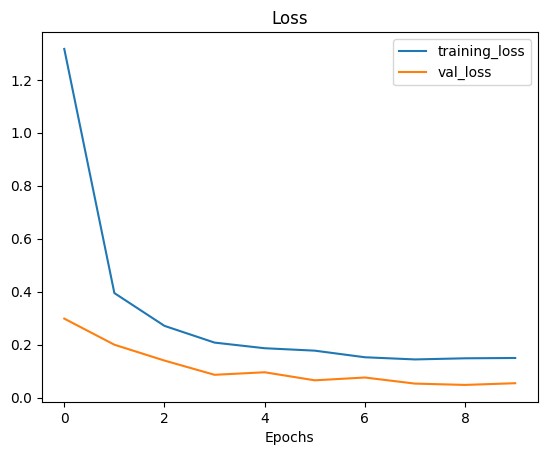

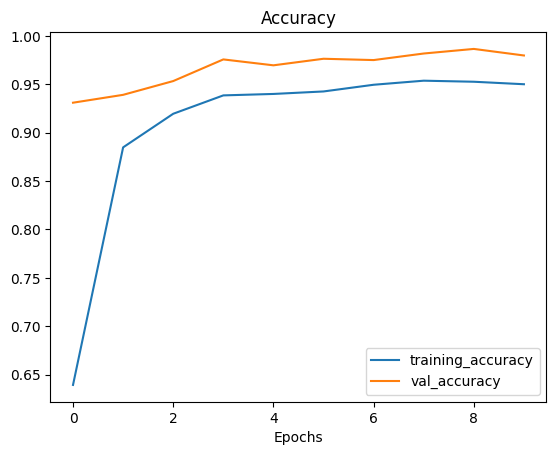

In [ ]:
plot_loss_curves(history)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step
The first 5 predictions: ['Nda', 'Ca', 'Nja', 'Ga', 'Ga']


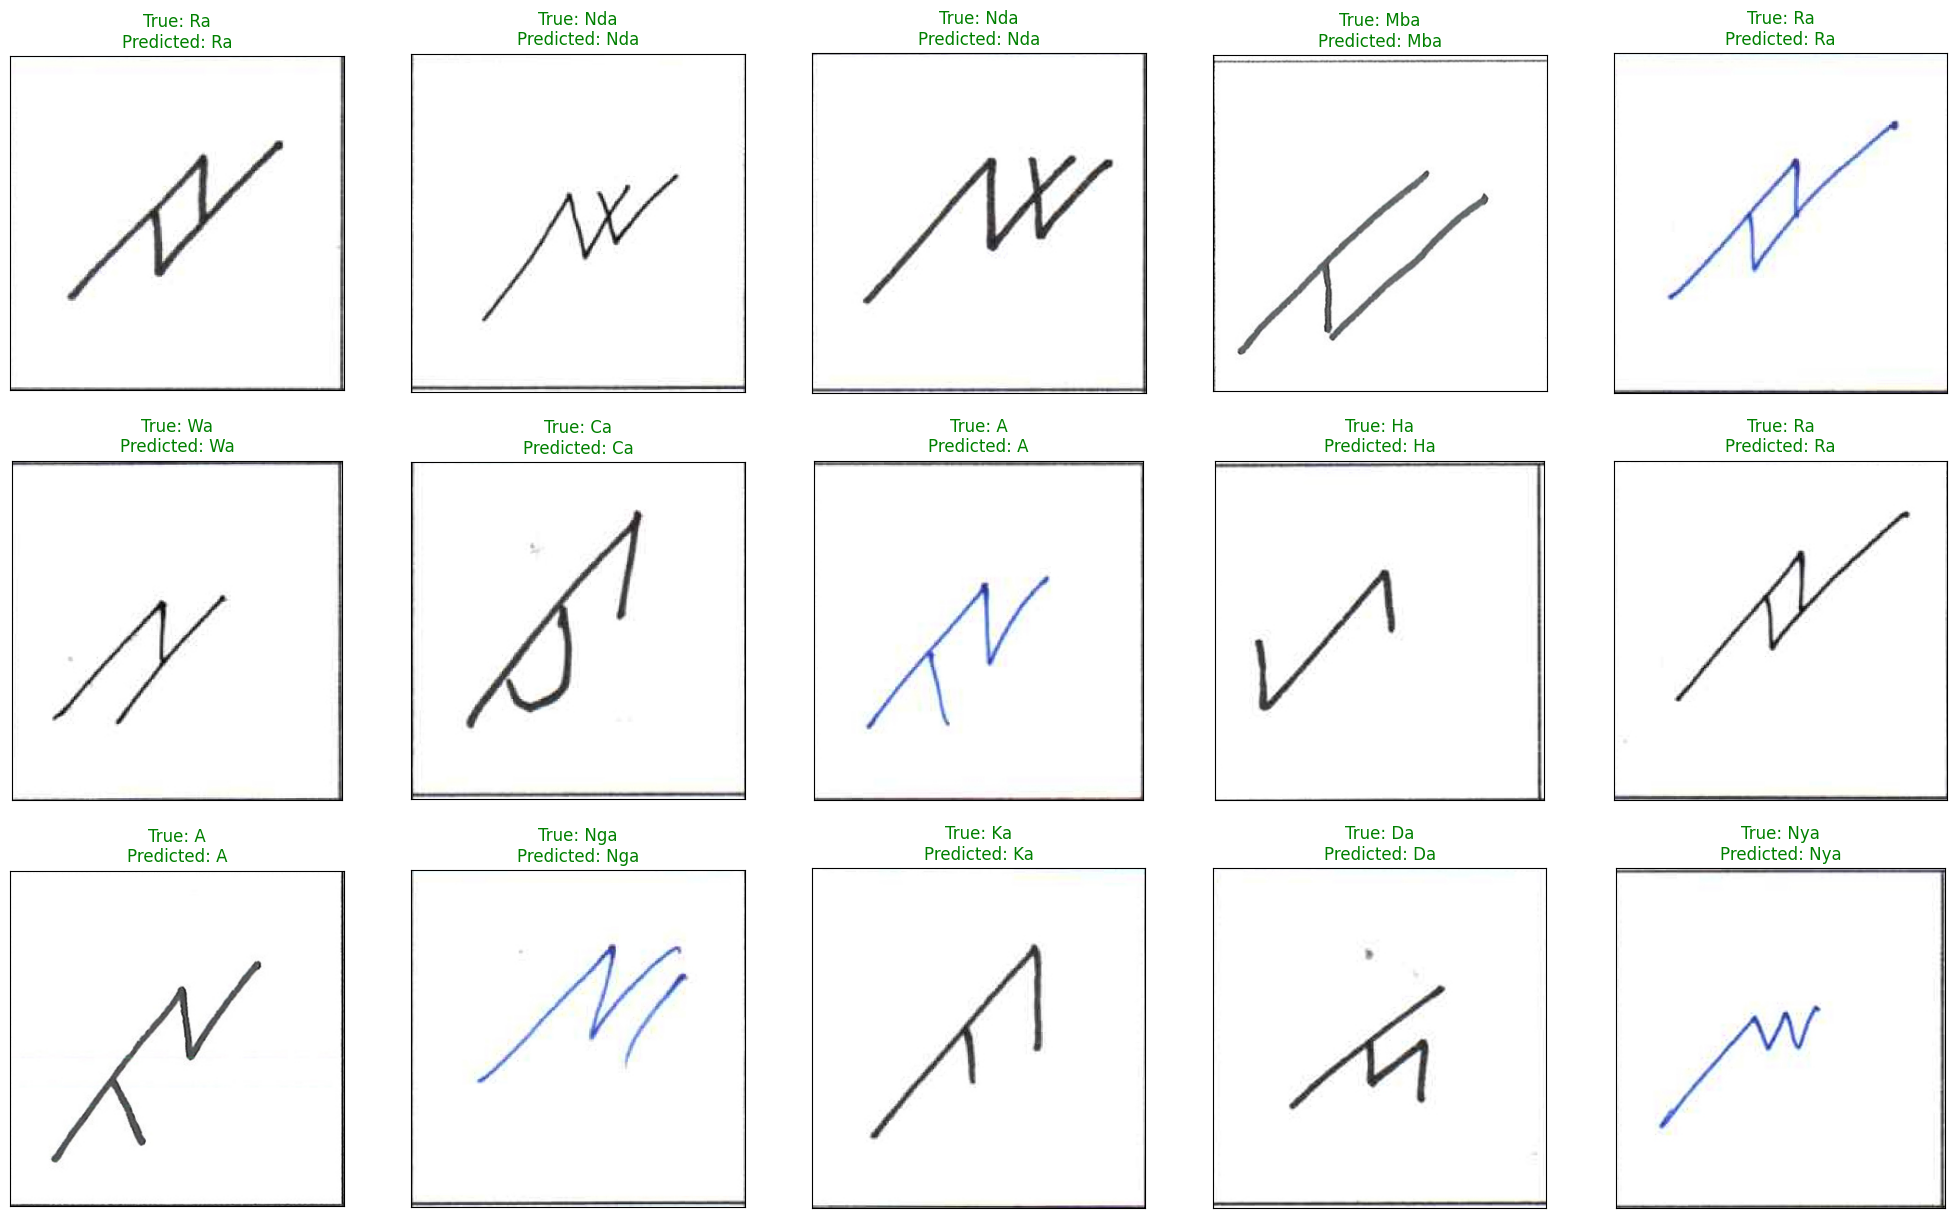

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 50)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# **Classification Report**

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       1.00      0.95      0.98        83
          Ba       1.00      1.00      1.00        76
          Ca       1.00      0.99      0.99        76
          Da       0.93      1.00      0.96        76
          Ga       0.97      1.00      0.98        86
          Ha       0.99      0.99      0.99        73
          Ja       0.95      0.96      0.96        78
          Ka       0.99      0.94      0.97        90
          La       0.96      0.99      0.97        74
          Ma       1.00      0.95      0.97        78
         Mba       0.96      0.99      0.97        89
          Na       0.97      0.94      0.95        79
         Nda       0.87      1.00      0.93        82
         Nga       0.99      0.86      0.92        78
        Ngga       0.99      1.00      0.99        78
         Nja       0.98      1.00      0.99        86
         Nya       0.95      0.97      0.96        80
          Pa       1.00    

# **Confusion Matrix**

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

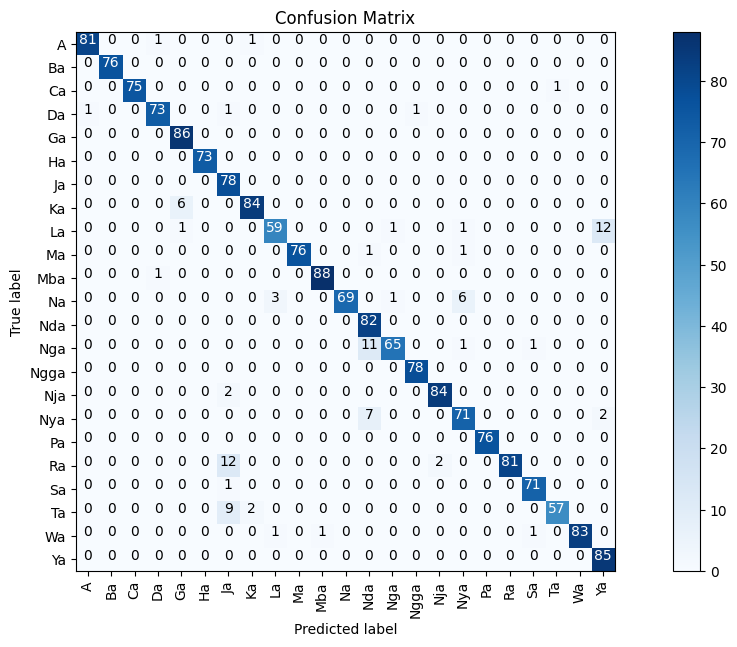

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# **Sistem Identifikasi Menggunakan Data Baru**

In [ ]:
import cv2
import numpy as np

# Load the image using OpenCV
image_path = '/content/drive/MyDrive/Colab Notebooks/data/aa.jpg'
image = cv2.imread(image_path)

# Preprocess the image to match the input shape expected by the model
image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)
image = image / 255.

# Make a prediction
predictions = model.predict(image)

# Get the predicted class label
class_label = np.argmax(predictions, axis=1)[0]

# Get the class label name
class_names = test_images.class_indices
class_name = [k for k, v in class_names.items() if v == class_label][0]

# Tentukan ambang batas
threshold = 0.8 # Sesuaikan nilai sesuai kebutuhan

# Use the class label as an integer
max_index = np.argmax(predictions[:, :class_label])

if predictions[0, max_index] < threshold:
    class_name = "bukan huruf kaganga"
else:
    # Cari kelas dengan probabilitas tertinggi
    class_label = np.argmax(predictions, axis=1)[0]
    class_name = [k for k, v in class_names.items() if v == class_label][0]

# Print the predicted class label
print(f'Huruf yang diprediksi merupakan huruf: {class_name}.')

# **Save model**


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/KaGaNga_Model_HW.h5')